**Crawling data** merupakan sebuah teknik pengumpulan data dimana data tidak ditulis secara manual melainkan menggunakan mesin. Salah satu library yang dapat digunakan untuk melakukan crawling adalah dengan menggunakan twint. twint merupakan libraby yang dapat digunakan untuk melakukan crawling data pada twitter. adapun persiapan yang harus dilakukan terlebih dahulu adalah menginstall jupyter-book sebagai tools untuk membuat konten.

Pertama-tama masuk ke folder webmining terlebih dahulu

Kemudian install twin dari github dengan code seperti berikut:

In [ ]:
!pip install git+https://github.com/twintproject/twint.git

Setelah itu install juga nest asynco

In [ ]:
!pip install nest_asyncio

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply() #digunakan sekali untuk mengaktifkan tindakan serentak dalam notebook jupyter.

Setelah data dicrawling selanjutnya dilakukan pra preprocessing atau bisa juga disebut **data cleaning**. Apa itu **data cleaning** ? data sudah bersih yang dimana pada data tersebut tidak terdapat url, emoji, backslice dan yang lainnya. Tujuan dari data cleaning yaitu agar data yang masuk kedalam mesin itu murni berupa data teks sehingga mesin lebih mudah dalam melakukan pembelajaran.

In [7]:
import pandas as pd
import numpy as np
data_tweet = pd.read_csv('data_tweet_new.csv') #membaca file csv dengan nama output
data_tweet.head()

,tweet
0,@geloraco Ya Allah....... Pantesan.... Bny war...
1,#TragediKanjuruhan Sanksi FIFA Tahun 2015 Sil...
2,Bukti Penting Tragedi Kanjuruhan Kini Dipegang...
3,Sekjen PSSI: Pemberhentian Kompetisi Tidak Ter...
4,Polisi di Kota Malang sujud minta maaf terkait...


Selanjutnya adalah mengganti data index 1 secara manual untuk menghapus emoji karena emoji tersebut tidak valid sehingga tidak bisa dihapus menggunakan mesin

**Case Folding**

In [ ]:
data_tweet["tweet"] = data_tweet["tweet"].str.lower()
data_tweet["tweet"]

**Cleaning Data**

In [ ]:
import nltk
import string
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

Yang pertama adalah menghapus url

In [ ]:
def remove_url(text):
  return re.sub(r'http\S+', '', text)
data_tweet["tweet"] = data_tweet["tweet"].apply(remove_url)

Selanjutnya adalah menghapus karekter spesial

In [ ]:
def remove_tweet_special(text):
  #remove tab, new line, and back slice
  text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
  #remove non ASCII (emoticon,chinese word,.etc)
  text = text.encode('ascii','replace').decode('ascii')
  #remove mention, link, hastag
  text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\s+)", " ", text).split())
  #remove incomplete url
  return text.replace("http://"," ").replace("https://"," ")
data_tweet["tweet"] = data_tweet["tweet"].apply(remove_tweet_special)

In [ ]:
def remove_number(text):
  return re.sub(r"\d+", "",text)
data_tweet["tweet"] = data_tweet["tweet"].apply(remove_number)

In [ ]:
def remove_punctuation(text):
  return text.translate(str.maketrans("","",string.punctuation))
data_tweet["tweet"] = data_tweet["tweet"].apply(remove_punctuation)

In [ ]:
def remove_whitespace(text):
  return text.strip()
data_tweet["tweet"] = data_tweet["tweet"].apply(remove_whitespace)

In [ ]:
def remove_singl_char(text):
  return re.sub(r"\b[a-zA-Z]\b","",text)
data_tweet["tweet"] = data_tweet["tweet"].apply(remove_singl_char)

In [ ]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)
data_tweet["tweet_tokens"] = data_tweet["tweet"].apply(word_tokenize_wrapper)

In [ ]:
data_tweet["tweet"].head()

In [ ]:
data_tweet["tweet_tokens"].head()

In [ ]:
def freqDist_wrapper(text):
  return FreqDist(text)

data_tweet["tweet_tokens_fdist"] = data_tweet["tweet_tokens"].apply(freqDist_wrapper)
data_tweet["tweet_tokens_fdist"].head()

**Stopwrord Removal**

In [ ]:
#import nltk untuk melakukan peprocessing data
import nltk
nltk.download('stopwords') #download stopword indonesia
from nltk.corpus import stopwords
stopword_language = stopwords.words('indonesian') #set stopword
stopword_language.extend(['jg','jos','yg','dg','dgn','rt','ny','d','klo','kalo',
                          'amp','biar','bikin','bilang','gak','ga','krn','nya','nih',
                          'sih','si','tau','tdk','tuh','utk','ya','jd','jgn','sdh','aja',
                          'n','t',
                          ])
txt_stopword = pd.read_csv('data_tweet_new.csv',names=['stopwords'],header=None)
stopword_language.extend(txt_stopword['stopwords'][0].split(' '))

In [ ]:
def stopword_removal(words):
  return [word for word in words if word not in stopword_language]

data_tweet["tweet_tokens_rstopword"] = data_tweet["tweet_tokens"].apply(stopword_removal)

**Normalisasi**

In [ ]:
normalized_word = pd.read_csv('data_tweet_new.csv')
normalized_word_dict = {}

for index,row in normalized_word_dict:
  if row[0] not in normalized_word_dict:
    normalized_word_dict[row[0]]=row[1]

def normalized_term(document):
  return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

data_tweet["tweet_normalized"] = data_tweet["tweet_tokens_rstopword"].apply(normalized_term)
data_tweet["tweet_normalized"].head()

**Stemming**

In [ ]:
!pip install sastrawi

In [ ]:
!pip install swifter

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
  return stemmer.stem(term)

term_dict = {}

for document in data_tweet['tweet_normalized']:
  for term in document:
    if term not in term_dict:
      term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
  term_dict[term] = stemmed_wrapper(term)

In [ ]:
def get_stemmed_term(document):
  return [term_dict[term] for term in document]

data_tweet["tweet_tokens_stemmed"] = data_tweet["tweet_normalized"].swifter.apply(get_stemmed_term)

In [ ]:
data_tweet.to_csv("preprocessing_tweet.csv")

**Membuat VSM**

In [ ]:
!pip install sklearn

In [8]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
titles = pd.read_csv('preprocessing_tweet.csv',sep=',',usecols=["tweet_tokens_stemmed"],squeeze=True)

docs = titles.values
bag = count.fit_transform(docs)
print(docs)

["['allah', 'pantesan', 'bny', 'warga', 'tinggal', 'tragedi', 'kanjuruhan']"
 "['sanksi', 'fifa', 'silam', 'ulang']"
 "['bukti', 'tragedi', 'kanjuruhan', 'pegang', 'komnas', 'ham']"
 "['sekjen', 'pssi', 'henti', 'kompetisi', 'level', 'grassroot', 'baca', 'berita', 'media', 'indonesia']"
 "['polisi', 'kota', 'malang', 'sujud', 'maaf', 'kait', 'tragedi', 'kanjuruhan']"
 "['tragedi', 'kanjuruhan', 'perintah', 'indonesia', 'waspada', 'sanksi', 'fifa']"
 "['imbas', 'tragedi', 'kanjuruhan']"
 "['ade', 'armando', 'polisi', 'lantar', 'sebut', 'aremania', 'sok', 'jago', 'ucap', 'lontar', 'ade', 'video', 'kait', 'tragedi', 'rusuh', 'stadion', 'kanjuruhan']"
 "['komnas', 'ham', 'klaim', 'video', 'kunci', 'tragedi', 'kanjuruhan']"
 "['aku', 'iwan', 'londo', 'tragedi', 'kanjuruhan', 'karna', 'cuan']"
 "['tragedi', 'kanjuruhan', 'indosiar', 'bantah', 'penting', 'iklan', 'rokok', 'tanding', 'arema', 'vs', 'baya', 'malam']"
 "['korban', 'tinggal', 'tragedi', 'kanjuruhan', 'tambah']"
 "['polisi', 'trag

In [ ]:
print(count.vocabulary_)

{'kocak': 342, 'banget': 56, 'gue': 222, 'ospek': 480, 'cuz': 124, 'dont': 158, 'have': 243, 'proper': 517, 'weekend': 668, 'nyadar': 461, 'minggu': 407, 'offline': 467, 'ootd': 475, 'gueee': 223, 'gajelasss': 185, 'bangettt': 57, 'weeee': 667, 'astagaaaa': 43, 'with': 670, 'cupy': 119, 'gladi': 214, 'bersih': 74, 'lu': 371, 'gimanaaa': 208, 'capek': 107, 'habis': 231, 'jurusanmakrab': 296, 'ngga': 448, 'kenal': 325, 'maksud': 382, 'surat': 598, 'kantor': 310, 'hrd': 259, 'izin': 276, 'gitu': 211, 'yu': 681, 'onlen': 473, 'mah': 378, 'diem': 145, 'aje': 15, 'ye': 676, 'wak': 664, 'hrs': 260, 'susul': 600, 'anjg': 28, 'jalan': 280, 'pintas': 506, 'jembatan': 288, 'btw': 99, 'uty': 659, 'kayak': 315, 'pake': 489, 'item': 272, 'putih': 522, 'adbis': 6, 'semangat': 558, 'abis': 4, 'lgsg': 359, 'kelas': 320, 'jam': 281, 'tuju': 638, 'anjir': 31, 'strong': 595, 'girls': 210, 'stream': 593, 'born': 91, 'pink': 505, 'souieii': 589, 'oalah': 465, 'kira': 335, 'kotak': 346, 'bekel': 67, 'is': 27

In [10]:
print(count.get_feature_names())
a = count.get_feature_names()

['aamiin', 'abdul', 'acara', 'aceh', 'ade', 'adil', 'aditya', 'aff', 'agama', 'agenda', 'ah', 'ahy', 'air', 'ajak', 'ajar', 'akan', 'akar', 'akbp', 'akibat', 'aku', 'akun', 'alami', 'alastua', 'alfatihah', 'alih', 'allah', 'alm', 'alvin', 'aman', 'amar', 'amat', 'ambil', 'anakseto', 'anget', 'anggap', 'angger', 'anggota', 'anwar', 'aparat', 'arema', 'aremania', 'arep', 'armando', 'aryana', 'asa', 'aspek', 'atu', 'audit', 'bab', 'baca', 'bagi', 'bahan', 'bahas', 'bahaya', 'baik', 'balas', 'balasanfifayg', 'baliho', 'bambanh', 'bangun', 'banjar', 'bantah', 'bantai', 'baru', 'bawa', 'baya', 'beda', 'beetuuul', 'bela', 'belo', 'benah', 'bencana', 'bengkulu', 'bentuk', 'benzema', 'berat', 'beres', 'berita', 'bert', 'bicara', 'bincang', 'biru', 'bkn', 'blm', 'blog', 'bner', 'bny', 'bohong', 'boikot', 'bola', 'breaking', 'brigjen', 'broadcaster', 'bs', 'bubar', 'budaya', 'bukti', 'bulan', 'buntut', 'bunuh', 'buzzer', 'cab', 'cantum', 'capai', 'cari', 'cebong', 'cecar', 'cepat', 'coba', 'cuan'

In [11]:
print(bag.toarray())
b = bag.toarray()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
dfa = pd.DataFrame(data=a)
num_rows = -1

for row in open("preprocessing_tweet.csv"):
  num_rows+=1

dfb = pd.DataFrame(data=b,index=range(0,num_rows),columns=[a])
dfb

,aamiin,abdul,acara,aceh,ade,adil,aditya,aff,agama,agenda,...,wenang,wes,widodo,wiyanto,yak,yangakan,yo,yunus,yuspahruddin,zat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**K-means Clustering** Merupakan sebuah metode untuk mengelompokkan data berdasarkan kemiripan dari data tersebut. berbeda dengan klasifikasi clustering mengelompokkan data yang unsupervised(tidak terawasi) atau belum memiliki label.

In [17]:
from sklearn.cluster import KMeans

kmeans =KMeans(n_clusters=2)
kmeans=kmeans.fit(dfb)
prediksi=kmeans.predict(dfb)
centroids = kmeans.cluster_centers_
prediksi
data=pd.DataFrame(prediksi,columns=["Cluster"])
data

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


,Cluster
0,0
1,1
2,0
3,1
4,0
...,...
213,0
214,0
215,0
216,0


In [18]:
dflabels = pd.read_csv('label.csv')
dfb['labels'] = dflabels
dfb

,aamiin,abdul,acara,aceh,ade,adil,aditya,aff,agama,agenda,...,wes,widodo,wiyanto,yak,yangakan,yo,yunus,yuspahruddin,zat,labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negatif
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positif
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positif
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negatif
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positif
214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negatif
215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negatif
216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positif


**Membagi data training dan data testing**

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(dfb.drop(labels=['labels'], axis=1),
    dfb['labels'],
    test_size=0.3,
    random_state=0)

In [20]:
y_test

,labels
201,positif
90,negatif
71,positif
144,negatif
55,negatif
...,...
26,negatif
8,positif
158,positif
75,negatif


**KNN**

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
testing=[]
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train.values, y_train)
Y_pred = neigh.predict(X_test.values) 
Y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array(['positif', 'positif', 'negatif', 'positif', 'positif', 'positif',
       'negatif', 'negatif', 'positif', 'positif', 'negatif', 'negatif',
       'positif', 'positif', 'positif', 'positif', 'positif', 'positif',
       'positif', 'negatif', 'negatif', 'positif', 'positif', 'negatif',
       'positif', 'positif', 'negatif', 'negatif', 'positif', 'positif',
       'positif', 'positif', 'negatif', 'positif', 'positif', 'negatif',
       'positif', 'negatif', 'positif', 'negatif', 'positif', 'positif',
       'positif', 'positif', 'positif', 'positif', 'positif', 'positif',
       'negatif', 'positif', 'positif', 'positif', 'negatif', 'positif',
       'positif', 'negatif', 'positif', 'positif', 'positif', 'negatif',
       'positif', 'negatif', 'positif', 'positif', 'negatif', 'positif'],
      dtype=object)

In [23]:
from sklearn.metrics import make_scorer, accuracy_score,precision_score
neigh.predict(X_test.values) 
accuracy_neigh=round(accuracy_score(y_test,Y_pred)* 100, 2)
acc_neigh = round(neigh.score(X_train.values, y_train) * 100, 2)
acc_neigh

72.37

# Bagging Classifier(Ensamble Learning)

**Grid Optimatization**

In [36]:
#kfold merupakan pembagian data, jika ada 1 fold testing maka sisanya adalah training
#sehingga semua data pernah menjadi bagian dari data testing dan data training
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
  
X = X_train
Y = y_train
  
seed = 8
  
# initialize the base classifier
base_cls = DecisionTreeClassifier()
  
# no. of base classifier
num_trees = 500
  
# bagging classifier
model = BaggingClassifier(base_estimator = base_cls,
                          n_estimators = num_trees,
                          random_state = seed)
  
results = model_selection.cross_val_score(model, X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packag

In [37]:
print("accuracy :")
print(results.mean())

accuracy :
0.6301075268817204


**Metode SVC**

In [29]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import pandas as pd

X = X_train.values
Y = y_train

# seed = 8
# kfold = model_selection.KFold(n_splits = 3,
# 					random_state = seed)

# initialize the base classifier
base_cls = SVC()

# no. of base classifier
num_trees = 500

# bagging classifier
model = BaggingClassifier(base_estimator = base_cls,
						n_estimators = num_trees)

results = model_selection.cross_val_score(model, X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [30]:
print("accuracy :")
print(results.mean())

accuracy :
0.6574193548387097


# Mutual Information

In [38]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.04165355, 0.08158987, 0.        , 0.        , 0.00822995,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05254923, 0.        , 0.        ,
       0.        , 0.00762908, 0.        , 0.        , 0.        ,
       0.10292161, 0.        , 0.        , 0.00124372, 0.        ,
       0.        , 0.06650552, 0.        , 0.05102316, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05663694, 0.01456855, 0.06357698, 0.06331606, 0.04757515,
       0.01475154, 0.00905491, 0.        , 0.01215143, 0.08590226,
       0.        , 0.        , 0.        , 0.        , 0.03653754,
       0.10439183, 0.        , 0.01742978, 0.06232912, 0.        ,
       0.0550934 , 0.01314508, 0.00811753, 0.06392338, 0.06986835,
       0.03889039, 0.        , 0.05041242, 0.        , 0.        ,
       0.02361851, 0.01015581, 0.00867914, 0.04063647, 0.03828677,
       0.01911954, 0.        , 0.        , 0.        , 0.     

In [34]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

dunia     0.189052
ra        0.131343
beres     0.123165
sjw       0.116900
tiket     0.114156
            ...   
nafas     0.000000
ferdy     0.000000
mundur    0.000000
fifa      0.000000
aamiin    0.000000
Length: 658, dtype: float64

# Text Summarization

In [39]:
import pandas as pd
data_berita = pd.read_csv('output_berita.csv')
data_berita.head()

,kalimat
0,Timnas Indonesia U-16 tertinggal 0-5 dari Mala...


In [40]:
import nltk
from nltk import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
sentence = sent_tokenize(data_berita['kalimat'][0])
print(sentence)
sentence_tokenize = pd.DataFrame(sentence)
sentence_tokenize.to_csv('sentence_berita.csv')

['Timnas Indonesia U-16 tertinggal 0-5 dari Malaysia U-16 di babak pertama laga terakhir Grup B Kualifikasi Piala Asia U-17 2023.', 'Lantas, bagaimana peluang Timnas Indonesia U-16 untuk lolos ke Piala Asia u-17 2023 jika kalah dari Malaysia?Ada 3 skenario Timnas Indonesia U-16 agar lolos ke Piala Asia U-16 2023.', 'Yakni menang, imbang, dan kalah.', 'Begini penjelasannya.', 'Kemenangan akan memastikan Timnas indonesia U-16 lolos otomatis ke Piala Asia U-17.', 'Tambahan tiga poin membuat Indonesia menjadi juara Grup B dengan nilai 12.', '2.', 'Imbang Hasil imbang membuat Timnas Indonesia U-16 tetap menjadi juara Grup B dengan nilai 10.', 'Skuad Garuda Asia lolos ke Piala Asia U-17 dengan nilai 10.', '3.', 'KalahBagaimana jika kalah?', 'Poin Timnas Indonesia U-16 masih tetap sembilan.', 'Sedangkan Malaysia menjadi juara Grup B dengan 10 poin dan lolos ke Piala Asia U-17.', 'Kans Timnas Indonesia U-16 ke Piala Asia U-17 belum tertutup.', 'Namun, Timnas Indonesia U-16 harus beradu nasib d

In [45]:
import pandas as pd
data_berita = pd.read_csv('sentence_berita.csv')
data_kalimat = pd.DataFrame(data_berita)
data_berita.head()

,kalimat
0,Timnas Indonesia U-16 tertinggal 0-5 dari Mala...
1,"Lantas, bagaimana peluang Timnas Indonesia U-1..."
2,"Yakni menang, imbang, dan kalah."
3,Begini penjelasannya.
4,Kemenangan akan memastikan Timnas indonesia U-...


In [46]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

count = CountVectorizer()
titles = pd.read_csv('sentence_berita.csv',sep=',',usecols=['kalimat'],squeeze=True)

docs = titles.values
bag = count.fit_transform(docs)
print(docs)

['Timnas Indonesia U-16 tertinggal 0-5 dari Malaysia U-16 di babak pertama laga terakhir Grup B Kualifikasi Piala Asia U-17 2023.'
 'Lantas, bagaimana peluang Timnas Indonesia U-16 untuk lolos ke Piala Asia u-17 2023 jika kalah dari Malaysia?Ada 3 skenario Timnas Indonesia U-16 agar lolos ke Piala Asia U-16 2023.'
 'Yakni menang, imbang, dan kalah.' 'Begini penjelasannya.'
 'Kemenangan akan memastikan Timnas indonesia U-16 lolos otomatis ke Piala Asia U-17.'
 'Tambahan tiga poin membuat Indonesia menjadi juara Grup B dengan nilai 12.'
 '2.'
 'Imbang Hasil imbang membuat Timnas Indonesia U-16 tetap menjadi juara Grup B dengan nilai 10.'
 'Skuad Garuda Asia lolos ke Piala Asia U-17 dengan nilai 10.' '3.'
 'KalahBagaimana jika kalah?'
 'Poin Timnas Indonesia U-16 masih tetap sembilan.'
 'Sedangkan Malaysia menjadi juara Grup B dengan 10 poin dan lolos ke Piala Asia U-17.'
 'Kans Timnas Indonesia U-16 ke Piala Asia U-17 belum tertutup.'
 'Namun, Timnas Indonesia U-16 harus beradu nasib den

In [47]:
cv_matrix = count.fit_transform(docs)
print(cv_matrix)

  (0, 92)	1
  (0, 28)	1
  (0, 2)	2
  (0, 85)	1
  (0, 15)	1
  (0, 45)	1
  (0, 17)	1
  (0, 9)	1
  (0, 65)	1
  (0, 41)	1
  (0, 83)	1
  (0, 23)	1
  (0, 40)	1
  (0, 68)	1
  (0, 8)	1
  (0, 3)	1
  (0, 4)	1
  (1, 92)	2
  (1, 28)	2
  (1, 2)	3
  (1, 15)	1
  (1, 45)	1
  (1, 68)	2
  (1, 8)	2
  (1, 3)	1
  :	:
  (16, 71)	1
  (16, 94)	1
  (16, 66)	1
  (16, 19)	1
  (16, 43)	1
  (16, 55)	2
  (16, 24)	1
  (16, 52)	1
  (16, 62)	1
  (16, 50)	1
  (16, 79)	1
  (16, 59)	1
  (16, 76)	1
  (17, 41)	1
  (17, 69)	1
  (17, 71)	1
  (17, 94)	1
  (17, 84)	1
  (17, 24)	1
  (17, 30)	1
  (17, 20)	1
  (17, 96)	1
  (17, 18)	1
  (17, 58)	1
  (17, 36)	1


In [48]:
print ("Term = ", (count.get_feature_names_out()))

Term =  ['10' '12' '16' '17' '2023' 'ada' 'agar' 'akan' 'asia' 'babak' 'bagaimana'
 'begini' 'belum' 'beradu' 'dan' 'dari' 'dengan' 'di' 'dihitung' 'diikuti'
 'dua' 'enam' 'garuda' 'grup' 'hanya' 'harus' 'hasil' 'imbang' 'indonesia'
 'ini' 'jadi' 'jika' 'juara' 'kalah' 'kalahbagaimana' 'kali' 'kalsemen'
 'kans' 'ke' 'kemenangan' 'kualifikasi' 'laga' 'lantas' 'lima' 'lolos'
 'malaysia' 'masih' 'memastikan' 'membuat' 'menang' 'mengikuti' 'menjadi'
 'nah' 'namun' 'nasib' 'negara' 'nilai' 'otomatis' 'pada' 'paling'
 'pasalnya' 'peluang' 'penentuan' 'penjelasannya' 'perhitungan' 'pertama'
 'peserta' 'pesertanya' 'piala' 'poin' 'rumit' 'runner' 'sama' 'sangat'
 'sebuah' 'sedangkan' 'sedikit' 'sembilan' 'setiap' 'situasi' 'skenario'
 'skuad' 'tambahan' 'terakhir' 'terbaik' 'tertinggal' 'tertutup' 'tetap'
 'tidak' 'tidaknya' 'tiga' 'tim' 'timnas' 'untuk' 'up' 'yakni' 'yang']


**Matrix Similaritas**

In [50]:
normal_matrix = TfidfTransformer().fit_transform(cv_matrix)
print(normal_matrix.toarray())
print(normal_matrix.T.toarray)

[[0.         0.         0.34124495 ... 0.         0.         0.        ]
 [0.         0.         0.34869812 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.49080165 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.16726128 0.         0.        ]
 [0.         0.         0.         ... 0.24912341 0.         0.31662514]]
<bound method _cs_matrix.toarray of <97x18 sparse matrix of type '<class 'numpy.float64'>'
	with 194 stored elements in Compressed Sparse Column format>>


**Membangun Graph**

In [51]:
import networkx as nx

In [52]:
res_graph = normal_matrix * normal_matrix.T
print(res_graph)

  (0, 16)	0.09503133762327742
  (0, 15)	0.10394169917446658
  (0, 5)	0.0703519093639089
  (0, 17)	0.07215465194672367
  (0, 12)	0.2189107357971013
  (0, 8)	0.15519046966113118
  (0, 14)	0.3607430151066206
  (0, 13)	0.29041452326571005
  (0, 11)	0.18626640824928425
  (0, 7)	0.15388795130684027
  (0, 4)	0.2624769428754799
  (0, 1)	0.4596065007978306
  (0, 0)	0.9999999999999999
  (1, 5)	0.0448035542960956
  (1, 10)	0.1817425700146179
  (1, 2)	0.061567335318778206
  (1, 12)	0.30960893348705837
  (1, 8)	0.32586083916742997
  (1, 14)	0.27575423261714266
  (1, 13)	0.4147941088458994
  (1, 11)	0.22105644071043662
  (1, 7)	0.14518839339292403
  (1, 4)	0.4441658731180864
  (1, 0)	0.4596065007978306
  (1, 16)	0.0330017777664844
  :	:
  (15, 14)	0.06784829946104953
  (15, 12)	0.051758659787407575
  (15, 7)	0.04387246761284117
  (15, 5)	0.052102089157805447
  (15, 0)	0.10394169917446658
  (15, 15)	1.0
  (16, 4)	0.06350705627083782
  (16, 8)	0.031840637033847596
  (16, 15)	0.13215011369827723
  (16,

In [53]:
nx_graph = nx.from_scipy_sparse_matrix(res_graph)

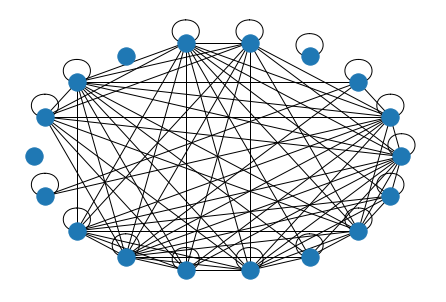

In [54]:
nx.draw_circular(nx_graph)

**Menghitung Page Rank**

In [55]:
ranks = nx.pagerank(nx_graph)

In [56]:
for i in ranks:
    print(i, ranks[i])

0 0.07123472072044089
1 0.08037775342067371
2 0.04686729416194815
3 0.06134969325153375
4 0.06864611065316496
5 0.059139554515384316
6 0.009202453987730064
7 0.0704381200808805
8 0.06656356139468829
9 0.009202453987730064
10 0.04471790945104781
11 0.05482690167970873
12 0.08141426388831766
13 0.06645945922060921
14 0.07021311268343106
15 0.04252521749258899
16 0.0537096876571239
17 0.0431117317529978


In [57]:
ranked_sentences = sorted(((ranks[i],s) for i,s in enumerate(docs)), reverse=True)

**Menampilkan 10 kalimat teratas**

In [58]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

Sedangkan Malaysia menjadi juara Grup B dengan 10 poin dan lolos ke Piala Asia U-17.
Lantas, bagaimana peluang Timnas Indonesia U-16 untuk lolos ke Piala Asia u-17 2023 jika kalah dari Malaysia?Ada 3 skenario Timnas Indonesia U-16 agar lolos ke Piala Asia U-16 2023.
Timnas Indonesia U-16 tertinggal 0-5 dari Malaysia U-16 di babak pertama laga terakhir Grup B Kualifikasi Piala Asia U-17 2023.
Imbang Hasil imbang membuat Timnas Indonesia U-16 tetap menjadi juara Grup B dengan nilai 10.
Namun, Timnas Indonesia U-16 harus beradu nasib dengan enam runner-up terbaik dari 10 grup peserta Kualifikasi Piala Asia U-17.Perhitungan lolos tidaknya sebuah tim di Kualifikasi Piala Asia U-17 kali ini sangat rumit.
Kemenangan akan memastikan Timnas indonesia U-16 lolos otomatis ke Piala Asia U-17.
Skuad Garuda Asia lolos ke Piala Asia U-17 dengan nilai 10.
Kans Timnas Indonesia U-16 ke Piala Asia U-17 belum tertutup.
Begini penjelasannya.
Tambahan tiga poin membuat Indonesia menjadi juara Grup B dengan